# CosmoSIS Introduction


CosmoSIS, the *COSMOlogical Survey Inference System*, is a framework for building inference pipelines, It is generically applicable, but has  a particular focus on cosmology analysis, and has an associated standard library of cosmology components.

This notebook will take you through the core design elements of CosmoSIS.  It only requires the core CosmoSIS python library, which can be installed with `pip install cosmosis`.  If you have trouble with that command, see our installation page.

Once that has worked, you can run this notebook.

In [1]:
%pylab inline
import cosmosis

Populating the interactive namespace from numpy and matplotlib


## Data Blocks

CosmoSIS stores the results of calculations in *Data Block* objects, which are containers for simple data types.  Having a single location for all the results of an analysis is very useful for debugging, among other things.

In python, you use an instance of the `DataBlock` class.  Blocks act a bit like dictionaries, except:
- they have two keys instead of just one: one general section, like "cosmological_parameters", and one more specific, like "Omega_m"
- the keys must be strings, and are always treated as lower-case
- their values are limited to int, double, str, and complex scalars or arrays
- once a value is added it can only be replaced with something of the same type
- there are a selection of additional methods to get a specific type of object from the block

Blocks can also be accessed from C, C++, Fortran, and Julia (or any language that can call C functions).

In [2]:
# make an empty block
block = cosmosis.DataBlock()

# put things in it in dictionary style. There are also equivalent "put" methods
block['section', 'a'] = 'value'
block['section', 'b'] = 42
block['section', 'c'] = [0.0, 1.2, 0.3]

# Now get things out, in a few ways
print(block['section', 'a'])
print(block.get_int('section', 'b'))
print(block.get_double_array_1d('section', 'c'))


# You can use the "default" argument to use the specific value
# if it is not found.  
print(block.get_double('section', 'key4', default=34.4))

# Note that this default value is afterwards included in the 
# datablock for future look-ups, to maintain consistency.
print(block['section', 'key4'])



value
42
[0.  1.2 0.3]
34.4
34.4


`DataBlock`s have lots of other methods - explore them here (by typing `block.` then pressing tab), and see what they do:


In [3]:
# Explore the other block methods here.
block.keys()

[('section', 'a'), ('section', 'b'), ('section', 'c'), ('section', 'key4')]

## Modules

CosmoSIS builds **pipelines** out of **modules**.  

Most realistic likelihoods in science are not the simple analytic functions that statisticians play with. They are usually long and involved calculations with many different steps and ingredients involved: pipelines.

The key idea in CosmoSIS is that you should break up these calculations into different stages, called moduled, each of which does a different physical calculation.  You can then mix and match different modules depending on exactly what calculations you are doing.

A pipeline is then a sequence of module objects.  You put a `DataBlock` in at the start of the pipeline, with your choice of parameters, and it is passed along from module to module, one by one.  Each one reads things from the block and adds the things it calculates.

Let's make a toy module out of the two functions we need to create, `setup` and `execute`.  Have a read of the comments along the way.


### Setup

The setup function will be called once per pipeline, at the start.
We use it to configure things that must be consistent throughout an analysis


In [4]:
def setup(options):
    # The options object is a DataBlock.  We use the special pre-defined section name
    # cosmosis.option_section to indicate that we want the options relevant to this
    # module (discussed below)
    degree = options.get_int(cosmosis.option_section, "degree")
    print(f"We will fit polynomials of degree {degree}")
    # This can return any python object.  In C, C++, or Fortran it would return a pointer.
    return {"degree": degree}

### Execute

The execute function will be called every time our pipeline is given new parameter values to run. It is usually the main workhorse of a module.


In [5]:
def execute(block, config):
    # "config" is just whatever we passed from setup, returned to us here
    degree = config['degree']

    # Let's imagine our first module is calculating a polynomial
    # function. Then the parameters it needs are the coefficients,
    # which we will name "p_0", "p_1", etc.
    coeffs = []
    for i in range(degree+1):
        coeffs.append(block['coefficients', f'p_{i}'])

    # Now we can make the polynomial x and y values,
    x = np.linspace(0, 1, 1000)
    y = np.zeros_like(x)
    for i in range(degree+1):
        y += coeffs[i] * x**i
        
    # and store them in the block for later modules
    # to use
    block['poly', 'x'] = x
    block['poly', 'y'] = y

    # we return 0 to indicate that everything worked.
    return 0

Now we have these two functions we can combine them into a module, which
we will give the name "poly":

In [6]:
poly_module = cosmosis.FunctionModule("poly", setup, execute)

### Configuring modules

Normally CosmoSIS does all the configuration and pipeline setup for you, by reading a pipeline from a file.  But we can do the same thing here manually to illustrate the process.

The code will automatically turn the right kind of dictionary to a datablock, so we can configure our module as below, which runs our setup script:
(in C and Fortran modules we normally read these directly from a configuration file).

In [7]:
params = {
    "poly": {
        "degree": 2
    }
}

poly_module.setup(params)

We will fit polynomials of degree 2


### Manually running modules

Again, the cosmosis core code will normally run your modules for you.  But we can manually do so, for example when debugging, or here to illustrate what happens under the hood.

We make a datablock with the initial parameters in. In a full cosmosis run the numbers would be generated by whatever sampler we are using (see below).  But here we will do it manually.

In [8]:
block = cosmosis.DataBlock()
block['coefficients', 'p_0'] = +1.0
block['coefficients', 'p_1'] = -1.0
block['coefficients', 'p_2'] = +2.0

Now we can execute our module, and see what the block looks like afterwards.

In [9]:
status = poly_module.execute(block)
print(f"Status = {status}")
print(block.to_string()[:200], '...')

Status = 0
coefficients:
  p_0: 1.0
  p_1: -1.0
  p_2: 2.0
poly:
  x:
  - 0.0
  - 0.001001001001001001
  - 0.002002002002002002
  - 0.003003003003003003
  - 0.004004004004004004
  - 0.005005005005005005
  - 0.00 ...


The module has added poly/x and poly/y to the block.  We've truncated them above because they are long, but let's plot them:

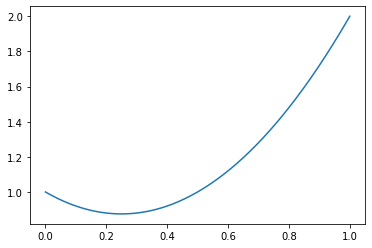

In [10]:
plot(block['poly', 'x'], block['poly', 'y'])

looks good!

### More modules

For a useful pipeline we will want more than one module. First, let's assume that our "theory model" polynomial gets raised to some power, and make a module for that.

We will make this module a little differently, using the cosmosis `ClassModule` parent class.



In [11]:
class PowerModule(cosmosis.ClassModule):
    # This parent class expects that the __init__ method is overridden,
    # matching the setup function in our first module.  
    def __init__(self, options):
        # In this class the options parameter has been trimmed to just be the options
        # specific to this module, so no funny 'cosmosis.options_section' is needed
        # when getting parameters
        self.exponent = options.get_double("exponent")
    
    # The execute method is exactly the same as the previous version
    def execute(self, block):
        block['poly', 'y'] = block['poly', 'y'] ** self.exponent

# The parent class has a method called as_module which converts this to a module
power_module = PowerModule.as_module("power")

### Likelihood modules

We usually end pipelines with one or more likelihood modules.  There's nothing special about these; any module that saves values to the "likelihoods" section of the block will do.  But because Gaussian likelihoods in particular are so common, CosmoSIS provides a parent class to do most of the work for you.

In [12]:
class Likelihood(cosmosis.GaussianLikelihood):
    # The likelihood will be saved with this name,
    # here target_like
    like_name = "target"

    # The parent class will look for these x and y values
    # in the block, and interpolate the data x and y values to them.
    # If interpolation is not suitable for your likelihood, you can
    # instead override the extract_theory_points method.
    x_section = "poly"
    x_name = "x"
    y_section = "poly"
    y_name = "y"
    
    def __init__(self, options):
        # The parent initializer calls the methods below
        # after setting self.options to this options object
        super().__init__(options)
        print("Created a new likelihood called", self.like_name)

    # This is called from setup to load or simulate the
    # data for the likelihood
    def build_data(self):
        # Let's make up some fake data to fit our model to
        x = np.array([0.2, 0.31, 0.44, 0.77, 0.9])
        y = (1.4 * x**2 - 3.1 * x - 0.8) ** 2
        return x, y

    # This is also called at the start to load the covariance
    # matrix.  You could also overrride build_inverse_covariance
    # if you have that already.
    def build_covariance(self):
        # We can read parameters from the config like this:
        noise_level = self.options['noise_level']
        sigma = np.array([0.05, 0.06, 0.04, 0.03, 0.1]) * noise_level
        return np.diag(sigma**2)

like_module = Likelihood.as_module("target")

Now we have three modules and can set them all up at once, from the same config information:

In [13]:
params = {
    "poly": {
        "degree": 2
    },
    "power": {
        "exponent": 2.0,
        "unused": 666,  # Unused params like this will trigger a warning
    },
    "target": {
        "noise_level": 1.0,
    }
}

poly_module.setup(params)
power_module.setup(params)
like_module.setup(params)

We will fit polynomials of degree 2
**** WARNING: Parameter 'unused' in the [power] section never used!

Created a new likelihood called target


and now we have manually built our own pipeline!  Let's a the block through all three modules in sequence:

In [14]:
block = cosmosis.DataBlock()
block['coefficients', 'p_0'] = +1.0
block['coefficients', 'p_1'] = -1.0
block['coefficients', 'p_2'] = +2.0
poly_module.execute(block)
power_module.execute(block)
like_module.execute(block)

0

The 0 indicates success.  Now we can see what likelihood is saved in our block:

In [15]:
print(block['likelihoods', 'target_like'])

-10451.228075986577


The likelihood has saved lots of things for us.  Explore the contents of the block yourself here:

In [16]:
# See what's in the block!

## Pipelines

CosmoSIS can do all the work of building and running pipelines for us. On the command line it would do all this from a configuration file.  Or we can build one manually.  Here's the full configuration info we will need:

In [17]:
# Configuration options for all our modules

params = {
    "poly": {
        "degree": 2
    },

    "power": {
        "exponent": 2.0,
    },

    "target": {
        "noise_level": 1.0,
    }
}

# The values can either contain individual values for parameters that are fixed,
# or ranges as strings: "min_value   start_value   max_value".
values = {
    "coefficients": {
        "p_0": "-5.   0.0   5.0",
        "p_1": "-5.   0.0   5.0",
        "p_2": "-5.   0.0   5.0",
    }
}


Now we can make our LikelihoodPipeline object.  This will set up our parameters automatically.

In [18]:
modules = [poly_module, power_module, like_module]
pipe = cosmosis.LikelihoodPipeline(params, values=values, modules=modules)

We will fit polynomials of degree 2
Created a new likelihood called target

Parameter Priors
----------------
coefficients--p_0  ~ U(-5.0, 5.0)
coefficients--p_1  ~ U(-5.0, 5.0)
coefficients--p_2  ~ U(-5.0, 5.0)



Let's look at some of the methods our pipeline now has:

In [19]:
print("Lower limits:", pipe.min_vector())
print("Upper limits:", pipe.max_vector())
print("Start point:", pipe.start_vector())

print("Converting to unit cube: ", pipe.normalize_vector([0.1, 0.2, 0.3]))

print("A likelihood:", pipe.likelihood([0.1, 0.2, 0.3]))
print("A prior:", pipe.prior([0.1, 0.2, 0.3]))
print("A posterior:", pipe.posterior([0.1, 0.2, 0.3]))



Lower limits: [-5. -5. -5.]
Upper limits: [5. 5. 5.]
Start point: [0. 0. 0.]
Converting to unit cube:  [0.51 0.52 0.53]
A likelihood: (-23169.040549987218, [])
A prior: -6.907755278982138
A posterior: (-23175.9483052662, [])


# Samplers

We can use our pipeline manually, but to really explore the parameter space we should use a sampler.  CosmoSIS wraps many things, and calls them all "samplers", even if some of them, like the maximum likelihood sampler we will use below, don't generate statistical samples.

Let's make and configure

In [20]:
# Each sampler has different configuration options.
sampler_params = {
    "maxlike": {
        # max_posterior only matters if you have non-uniform priors
        # on parameters. It won't make any difference here.
        "max_posterior": True,
        "toleratnce": 0.01
    }
}

# Make a Maxlike sampler  There are many samplers to choose from!
sampler = cosmosis.samplers.MaxlikeSampler(sampler_params, pipe)

# The config method sets up the sampler.  It assumes the pipeline has already been configured.
sampler.config()

------------------------------------------------
NOTE: Running optimizer in **max-posterior** mode:
NOTE: Will maximize the combined likelihood and prior
------------------------------------------------


We run the sampler using the "execute" method:

In [21]:
sampler.execute()

0.7996032594329305   3.1023618511426747   -1.4024698938185725




Optimization terminated successfully.
         Current function value: 6.908002
         Iterations: 81
         Function evaluations: 141


The sampler's results are recorded in its `output` attribute.  The default output here just stores the results in lists, but when running from the command line they will be stored in text files instead.

When they are stored as text, cosmosis parameter names are stored as {section}--{key}, such as coefficients--p_2 here

In [22]:
print("Best-fit quadratic (truth=1.4):", sampler.output['coefficients--p_2'])
print("Best-fit linear (truth=-3.1):", sampler.output['coefficients--p_1'])
print("Best-fit constant (truth=-0.8):", sampler.output['coefficients--p_0'])

Best-fit quadratic (truth=1.4): [-1.40246989]
Best-fit linear (truth=-3.1): [3.10236185]
Best-fit constant (truth=-0.8): [0.79960326]


Interesting - these values may be negative (this will depend on your random number generator).  You have may spotted this when we wrote down the model!

Let's explore this further using a proper MCMC sampler, in this case `emcee`.

In [23]:
# We can include other sections in our sampler params.  In fact you can use the same configuration
# for the modules too.
sampler_params = {
    "maxlike": {
        "max_posterior": True,
        "toleratnce": 0.01
    },
    
    "emcee": {
        "walkers": 16,
        "samples": 1000,
        "steps": 100,
    }
}
sampler = cosmosis.samplers.EmceeSampler(sampler_params, pipe)
sampler.config()
sampler.execute()

Begun sampling


/Users/jzuntz/src/cosmosis/env/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Done 100 iterations of emcee. Acceptance fraction 0.272


Some samplers, like this one, do a chunk of work (specified here by the `steps` parameter) and then pause sampling to write out the results.  If you want to keep going until the sampler has done the full number of samples, you can use this approach:

In [24]:
# Note that "is_converged" here just means "is_finished" for emcee.  Some samplers have built-in convergence
# testing but not this one.
while not sampler.is_converged():
    sampler.execute()

Done 200 iterations of emcee. Acceptance fraction 0.255
Done 300 iterations of emcee. Acceptance fraction 0.272
Done 400 iterations of emcee. Acceptance fraction 0.282
Done 500 iterations of emcee. Acceptance fraction 0.288
Done 600 iterations of emcee. Acceptance fraction 0.292
Done 700 iterations of emcee. Acceptance fraction 0.294
Done 800 iterations of emcee. Acceptance fraction 0.296
Done 900 iterations of emcee. Acceptance fraction 0.300
Done 1000 iterations of emcee. Acceptance fraction 0.301


Now the sampler has finished we can plot the parameters as they explore the space

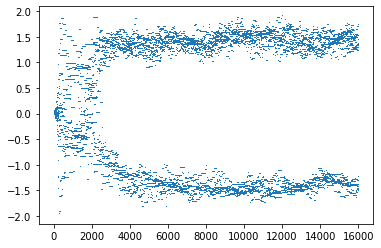

In [25]:
# Now we can pull out the samples 
p0_samples = sampler.output['coefficients--p_0']
p1_samples = sampler.output['coefficients--p_1']
p2_samples = sampler.output['coefficients--p_2']
plot(p2_samples, ',')

Aha, multiple peaks in our likelihood!  That makes sense given our model, which squared our polynomial, so flipping the signs on all the parameters works just as well.  Let's do a scatter plot to see this more clearly.

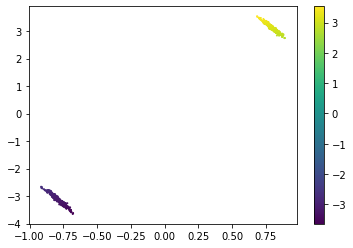

In [26]:
# We will use a cut to burn the first 10,000 samples, based on our plot above, and then
# thin the remaining chain by 5 samples
cut = slice(10000, None, 5)

scatter(p0_samples[cut], p1_samples[cut], c=p1_samples[cut], s=1)
colorbar()


As you can see there are two clear peack in our likelihood, with all three parameters inverted between the two.


# More information

This notebook has introduced the core CosmoSIS concepts.  The other notebooks will explain post-processing to get plots and statistics from cosmosis output, and if you are a cosmologist you should check out the cosmosis standard library demods which build more realistic pipelines.